## Init

In [49]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import time

import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
# from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## TicTacToe Env

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win
            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i, j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
            ### +1 is done so that every cell takes only 1 symbol (-1 takes two without this)
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0
        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}
        ### state, reward, done, {}
        ### state is (self.getHash(), self.getEmptySpaces(), self.curTurn) == str of (field values + 1), nparray of row, col indices for emptyspaces, next sym: either cross 1 or nought -1
        ### reward is either 0 if not done or if it's a draw, else 1 if crosses has won or -1 if noughts has won

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

        ### starting with cross (== 1)



        pass
        ####

In [ ]:
#

In [ ]:
#

In [5]:
def plot_board(env, pi = None, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i, a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [6]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        # print(observation)
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [ ]:
# env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

### Exploration of env & actions 

In [ ]:
# EMPTY_POS_KEY = '1'

# def get_valid_actions(state):
#     return np.where(np.array(list(state)) == EMPTY_POS_KEY)[0] ### [0] as np.where always returns tuple of lists of indices

# def get_invalid_actions(state):
#     return np.where(np.array(list(state)) != EMPTY_POS_KEY)[0]

In [ ]:
#env.step(action) -> (hash, EmptySpaces, curTurn), reward, done, {}

# env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
# env.reset()
# boardhash, current_turn = env.getHash(), env.curTurn
# for _ in range(5):
#     print(boardhash, current_turn)
#     valid_actions = get_valid_actions(boardhash)
#     action_as_int = np.random.choice(valid_actions)
#     action_as_coordinates = env.action_from_int(action_as_int)
#     (boardhash, _, current_turn), reward, done, _ = env.step(action_as_coordinates)

## Часть первая: крестики-нолики при помощи Q-обучения

В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

Disclaimer: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


## Player Classes

In [62]:
from typing import List, Tuple, Set, Union, Dict
from collections import deque, defaultdict

EMPTY_POS_KEY = '1'

class Player:
    def __init__(self, field_length_width = 3, alpha = 0.05, gamma = 0.9, epsilon = 0.1, Q = None):
        self.alpha = alpha ### learning rate
        self.gamma = gamma  ### discount
        self.epsilon = epsilon ### for greedy strategy
        # self.BOARD_SIZE = N_ROWS * N_COLS ### kinda not cool, but whatever..
        self.field_length_width = field_length_width
        self.board_size = field_length_width * field_length_width
        self.Q = Q if Q is not None else defaultdict(lambda: np.random.rand(self.board_size))
        
        self.state = None ### last state
        self.action = None ### last action made in that state

    def get_random_action(self, state: str) -> int:
        valid_actions = self.get_valid_actions(state)
        action = int(np.random.choice(valid_actions))
        self.state, self.action = state, action
        return action

    def get_best_action(self, state: str) -> int:
        return self.get_random_action(state)
    
    def get_action(self, state: str) -> int:
        return self.get_random_action(state)

    @staticmethod
    def get_valid_actions(state: str) -> List:
        ### state as a string of {'1', '2', '0'}
        return np.where(np.array(list(state)) == EMPTY_POS_KEY)[0] ### [0] as np.where always returns tuple of lists of indices
    
    @staticmethod
    def get_invalid_actions(state: str) -> List:
        ### state as a string of {'1', '2', '0'}
        return np.where(np.array(list(state)) != EMPTY_POS_KEY)[0]

    def make_update(self, state, action, next_state, reward):        
        if state is not None and action is not None:
            self.update_Q(state, action, next_state, reward)

    def update_Q(self, state, action, next_state, reward) -> None:
        self.Q[state][action] = self.Q[state][action] + self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

In [63]:
class EpsilonGreedyPlayer(Player):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_best_action(self, state: str) -> int:
        invalid_actions = self.get_invalid_actions(state)
        self.Q[state][invalid_actions] = -np.inf
        action = int(np.argmax(self.Q[state]))
        self.state, self.action = state, action
        return action

    def get_action(self, state: str) -> int:
        if np.random.random() < self.epsilon:
            return self.get_random_action(state)
        else:
            return self.get_best_action(state)

## Game Session

In [59]:
class GameSession:
    def __init__(self, env, cross_player = None, nought_player = None):
        self.env = env
        self.env.reset()
        self.players = {
            1  : cross_player if cross_player else Player(self.env.n_rows), ### cross player
            -1 : nought_player if nought_player else Player(self.env.n_rows), ### nought player
        }
        
    def get_cross_player(self):
        return self.players[1]

    def get_nought_player(self):
        return self.players[-1]    

    def run_episode(self, learn, verbose = False, ):
        self.env.reset()
        state, current_turn, done = self.env.getHash(), self.env.curTurn, self.env.gameOver
        env_reward = 0
        while not done:
            if verbose:
                print(state, current_turn)
            player = self.players[current_turn]

            action = player.get_action(state)
            action_as_coordinates = self.env.action_from_int(action)
            (next_state, _, next_turn), env_reward, done, _ = self.env.step(action_as_coordinates)
            other_player = self.players[next_turn]
            
            if done:
                ### adjusting env_reward for players: 0 stays 0, otherwise becomes 1 if reward coincides with current player's code (-1 or 1) and -1 otherwise
                ### last action for player which is not current actually made him lose (or win, but tbh you can't win on opponent's move in this setting)
                ### but he only knows this now
                reward = env_reward * current_turn
                if learn:
                    player.make_update(state, action, next_state, reward)
                    other_player.make_update(other_player.state, other_player.action, state, -reward)
            else:
                if learn:
                ### not over so last move by opponent didn't make him lose
                    other_player.make_update(other_player.state, other_player.action, state, 0)
        
            state = next_state
            current_turn = next_turn

        if verbose:
            plot_board(self.env)
            if env_reward == 1:
                print("Крестики выиграли!")
            elif env_reward == -1:
                print("Нолики выиграли!")
            else:
                print("Ничья!")
            
        return env_reward

def evaluate_player(session, cross: bool, n_episodes = 100):
    if cross:
        player = session.get_cross_player()
        new_session = GameSession(deepcopy(session.env), cross_player = player, nought_player = None)
    else:
        player = session.get_nought_player()
        new_session = GameSession(deepcopy(session.env), cross_player = None, nought_player = player)
    
    rewards = []
    for _ in range(n_episodes):
        reward = new_session.run_episode(learn = False) * (1 if cross else -1)
        rewards.append(reward)
    return np.mean(rewards)

def get_moving_average(x, window_size = 5) :
    return np.convolve(x, np.ones((window_size, )) / window_size, mode = 'valid')

### 3x3

##### Check mean rewards for random players without learning

In [60]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
game_session = GameSession(env)

evaluate_player(game_session, cross = True, n_episodes=1000), evaluate_player(game_session, cross = False,  n_episodes=1000)

(0.334, -0.287)

#### Q-learning

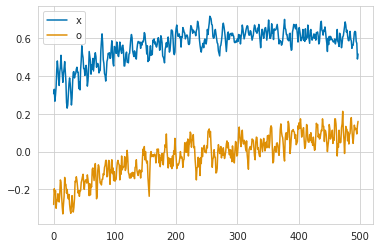

In [65]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

N_STEPS = 500
N_LEARNING_EPISODES = 500

ALPHA = 0.01
GAMMA = 0.9
EPSILON = 0.3


game_session = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = EpsilonGreedyPlayer(field_length_width = N_ROWS, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON,),
    nought_player = EpsilonGreedyPlayer(field_length_width = N_ROWS, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON,)
)

crosses_results, noughts_results = [], []

for _ in tqdm(range(N_STEPS)):

    for _ in range(N_LEARNING_EPISODES):
        game_session.run_episode(learn = True)

    clear_output()    

    crosses_results.append(evaluate_player(game_session, cross = True))
    noughts_results.append(evaluate_player(game_session, cross = False))

    plt.plot(get_moving_average(crosses_results, 3), label = "x")
    plt.plot(get_moving_average(noughts_results, 3), label = "o")
    plt.legend();
    plt.show();
    time.sleep(0.5)

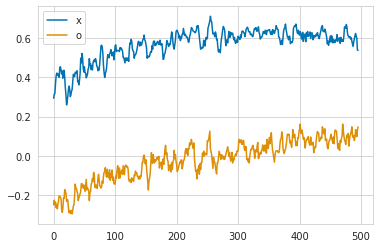

In [66]:
plt.plot(get_moving_average(crosses_results), label = "x")
plt.plot(get_moving_average(noughts_results), label = "o")
plt.legend();

### 4x4

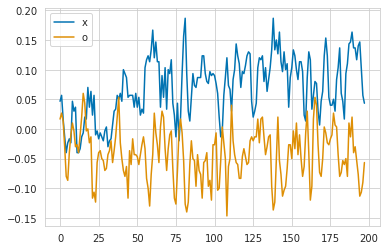

In [70]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

N_STEPS = 200
N_LEARNING_EPISODES = 500

ALPHA = 0.01
GAMMA = 0.9
EPSILON = 0.3

game_session = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = EpsilonGreedyPlayer(field_length_width = N_ROWS, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON,),
    nought_player = EpsilonGreedyPlayer(field_length_width = N_ROWS, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON,),
)
crosses_results, noughts_results = [], []

for _ in tqdm(range(N_STEPS)):

    for _ in range(N_LEARNING_EPISODES):
        game_session.run_episode(learn = True)
    
    clear_output()

    crosses_results.append(evaluate_player(game_session, cross = True))
    noughts_results.append(evaluate_player(game_session, cross = False))

    plt.plot(get_moving_average(crosses_results, 3), label = "x")
    plt.plot(get_moving_average(noughts_results, 3), label = "o")
    plt.legend();
    plt.show();
    time.sleep(0.5)

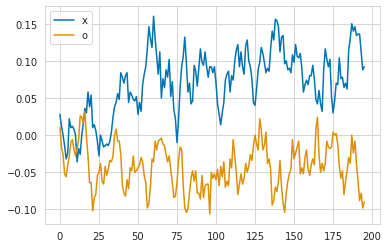

In [71]:
plt.plot(get_moving_average(crosses_results), label = "x")
plt.plot(get_moving_average(noughts_results), label = "o")
plt.legend();

## Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов.
Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Реализуйте Double DQN и/или Dueling DQN.


In [72]:
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F

In [73]:
class ConvNet(nn.Module):
    def __init__(self, n_channels = 1, kernel_size = 3, hidden_dim = 16, n_actions = 9):
        super().__init__()
        self.n_channels = n_channels
        self.hidden_dim = hidden_dim
        self.conv_layer = nn.Conv2d(
            in_channels = 1,
            out_channels = n_channels,
            kernel_size = kernel_size,
        )
        self.linear_layer = nn.Linear(n_channels, hidden_dim)
        self.activation = nn.ReLU() #nn.ELU() 
        self.out_layer = nn.Linear(hidden_dim, n_actions)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = self.conv_layer(state)
        # x = F.max_pool2d(x)
        x = F.adaptive_max_pool2d(x, (1, 1)).view(-1, self.n_channels)
        x = self.activation(x)
        x = self.linear_layer(x)
        x = self.activation(x)
        x = self.out_layer(x)
        return x

In [74]:
class ExperienceReplay:
    def __init__(self, maxlen = 100000):
        self.buffer = deque(maxlen = maxlen)
    def __len__(self):
        return len(self.buffer)
    def append(self, transition: Tuple):
        self.buffer.append(transition)
    def sample(self, size):
        batch = random.sample(self.buffer, size)
        return list(zip(*batch))

In [84]:
STEPS_PER_UPDATE = 5
STEPS_PER_TARGET_MODEL_UPDATE = 1000

GRADIENT_CLIP = 1

class DQN:
    def __init__(self, n_channels, kernel_size, hidden_dim, n_actions, lr, gamma, field_length_width, buffer, batch_size, hard_update, device = None):
        super().__init__()
                
        self.lr = lr
        self.gamma = gamma
        self.field_length_width = field_length_width

        self.device = device if device else 'cpu'
        self.model = ConvNet(n_channels, kernel_size, hidden_dim, n_actions).to(self.device)
        self.target_model = ConvNet(n_channels, kernel_size, hidden_dim, n_actions).to(self.device)
        self.target_model.load_state_dict(deepcopy(self.model.state_dict()))
        self.target_model.eval()

        self.tau = 0.001
        self.hard_update = hard_update 

        self.criterion = F.smooth_l1_loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr)

        self.steps = 0
        self.buffer = buffer
        self.batch_size = batch_size
        

    def eval(self):
        self.model.eval()

    def __call__(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def soft_update(self):
        for target_p, p in zip(self.target_model.parameters(), self.model.parameters()):
            target_p.data.copy_(self.tau * p + (1 - self.tau) * target_p)        

    def update_target_model(self):
        if self.hard_update:
            if (self.steps + 1) % STEPS_PER_TARGET_MODEL_UPDATE == 0:
                self.target_model.load_state_dict(deepcopy(self.model.state_dict()))
        else:
            self.soft_update()

        self.target_model.eval()

    def consume_transition(self, transition):
        self.buffer.append(transition)

    def sample_batch(self):
        batch_size = min(self.batch_size, len(self.buffer))
        return self.buffer.sample(batch_size)

    def update(self, transition):
        self.consume_transition(transition)
        if (self.steps + 1) % STEPS_PER_UPDATE == 0:
            if len(self.buffer) >= self.batch_size:
                batch = self.sample_batch()
                self.make_train_step(batch)
        self.update_target_model()
        self.steps += 1        

    def make_train_step(self, batch):

        self.model.train()
        state_idx, action_idx, next_state_idx, reward_idx = range(4)

        states = torch.stack(batch[state_idx], dim = 0).to(self.device) ### batch_size x 1 x n_rows x n_cols
        actions = torch.Tensor(batch[action_idx]).long().unsqueeze(1).to(self.device) ### batch_size x 1 - locs of selected actions
        next_states = torch.stack(batch[next_state_idx], dim = 0).to(self.device) ### batch_size x 1 x n_rows x n_cols
        rewards = torch.Tensor(batch[reward_idx]).unsqueeze(1).to(self.device) ### batch_size x 1 - rewards

        action_values_by_states = self.model(states)
        selected_action_values = action_values_by_states.gather(1, actions) ### along 'n_actions' dimension for each obs in batch - taking only those that were argmax when action was actually made

        with torch.no_grad():
            Q_approx_from_target_model = self.target_model(next_states).max(1)[0].detach().unsqueeze(1)
            ### max along 'n_actions' dimension for each obs in batch, then [0] for values themselves ([1] for argmax values), then returning batch dimension
            Q_values = rewards + Q_approx_from_target_model * self.gamma

        loss = self.criterion(selected_action_values, Q_values)

        self.optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), GRADIENT_CLIP)
        loss.backward()
        self.optimizer.step()

### DQNPlayer

In [85]:
class PlayerDQN(Player):
    def __init__(
        self, field_length_width = 3, buffer = None,
        n_channels = 3, kernel_size = 3, hidden_dim = 64,
        alpha = 0.005, gamma = 0.9, epsilon = 0.1,
        batch_size = 128, hard_update = False,
    ):

        self.buffer = buffer if buffer else ExperienceReplay()
        self.epsilon = epsilon
        self.field_length_width = field_length_width

        self.alpha = alpha ### learning rate
        self.gamma = gamma  ### discount
        self.epsilon = epsilon ### for greedy strategy
        self.n_actions = field_length_width * field_length_width

        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = DQN(
            n_channels = n_channels, kernel_size = kernel_size, hidden_dim = hidden_dim, n_actions = self.n_actions,
            lr = alpha, gamma = gamma, field_length_width = field_length_width,
            buffer = self.buffer, batch_size = batch_size, hard_update = hard_update,
            device = self.device,
        )
        
        self.state = None ### last state
        self.action = None ### last action made in that state

        self.minus_infinity = -1e9
        
    def update(self, state, action, next_state, reward):
        self.model.update(
            (
                self.state_string_to_square_field_tensor(state, self.field_length_width),
                action,
                self.state_string_to_square_field_tensor(next_state, self.field_length_width),
                reward
            )
        )
            
    @staticmethod
    def state_string_to_square_field_tensor(state: str, field_length_width: int):
        ### returns tensor of shape [1, LW, LW]
        tensor_2d = torch.Tensor(np.array(list(state)).astype(float).reshape(field_length_width, field_length_width))
        return tensor_2d.unsqueeze(0)#.view(1, field_length_width, field_length_width)

    def get_best_action(self, state: str) -> int:
        invalid_actions = self.get_invalid_actions(state)
        state_tensor = self.state_string_to_square_field_tensor(state, self.field_length_width).unsqueeze(0) ### adding batch dim
        self.model.eval()
        with torch.no_grad():
            model_actions = self.model(state_tensor.to(self.device)).detach().cpu()
        actions = model_actions.flatten()
        actions[invalid_actions] = self.minus_infinity
        action = int(actions.argmax().item())
        self.state, self.action = state, action
        return action

    def get_action(self, state: str) -> int:
        if np.random.rand() < self.epsilon:
            return self.get_random_action(state)
        else:
            return self.get_best_action(state)

    def make_update(self, state, action, next_state, reward):        
        if state is not None and action is not None:
            self.update(state, action, next_state, reward)

### 3x3

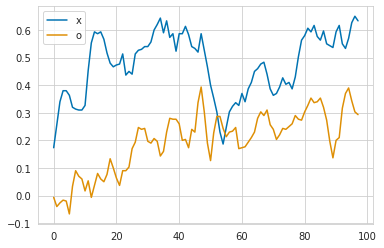

In [79]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

STEPS_PER_UPDATE = 5
STEPS_PER_TARGET_MODEL_UPDATE = 1000

N_STEPS = 100
N_LEARNING_EPISODES = 500

LR = 1e-5
N_CHANNELS = 3
EPS = 0.1
BATCH_SIZE = 256
HIDDEN_DIM = 16
KERNEL_SIZE = 3
HARD_UPDATE = True

game_session = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),
    nought_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),
)

game_session_cross = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),
    nought_player = Player(),
)

game_session_nought = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = Player(),
    nought_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),   
)

crosses_results, noughts_results = [], []

for _ in range(N_STEPS):

    for _ in range(N_LEARNING_EPISODES):
        # game_session.run_episode(learn = True, verbose = False)
        game_session_cross.run_episode(learn = True)
        game_session_nought.run_episode(learn = True)
        # game_session_nought = game_session_cross = game_session

    clear_output()    

    crosses_results.append(evaluate_player(game_session_cross, cross = True))
    noughts_results.append(evaluate_player(game_session_nought, cross = False))
    plt.plot(get_moving_average(crosses_results, 3), label = "x")
    plt.plot(get_moving_average(noughts_results, 3), label = "o")
    plt.legend();
    plt.show();
    time.sleep(0.5)
    
    

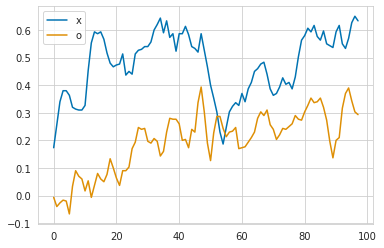

In [80]:
plt.plot(get_moving_average(crosses_results, 3), label = "x")
plt.plot(get_moving_average(noughts_results, 3), label = "o")
plt.legend();

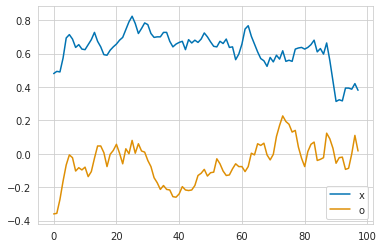

In [86]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

STEPS_PER_UPDATE = 10
STEPS_PER_TARGET_MODEL_UPDATE = 1000

N_STEPS = 100
N_LEARNING_EPISODES = 500

LR = 1e-4
N_CHANNELS = 16
EPS = 0.1
BATCH_SIZE = 256
HIDDEN_DIM = 64
KERNEL_SIZE = 3
HARD_UPDATE = False

game_session = GameSession(
    env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
    cross_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),
    nought_player = PlayerDQN(
        field_length_width = N_ROWS, alpha = LR,
        n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
        batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
    ),
)

# game_session_cross = GameSession(
#     env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
#     cross_player = PlayerDQN(
#         field_length_width = N_ROWS, alpha = LR,
#         n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
#         batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
#     ),
#     nought_player = Player(),
# )

# game_session_nought = GameSession(
#     env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN),
#     cross_player = Player(),
#     nought_player = PlayerDQN(
#         field_length_width = N_ROWS, alpha = LR,
#         n_channels = N_CHANNELS, kernel_size = KERNEL_SIZE, hidden_dim = HIDDEN_DIM,
#         batch_size = BATCH_SIZE, hard_update = HARD_UPDATE, epsilon = EPS,
#     ),   
# )

crosses_results, noughts_results = [], []

for _ in range(N_STEPS):

    for _ in range(N_LEARNING_EPISODES):
        game_session.run_episode(learn = True, verbose = False)
        # game_session_cross.run_episode(learn = True)
        # game_session_nought.run_episode(learn = True)
        game_session_nought = game_session_cross = game_session

    clear_output()    

    crosses_results.append(evaluate_player(game_session_cross, cross = True))
    noughts_results.append(evaluate_player(game_session_nought, cross = False))
    plt.plot(get_moving_average(crosses_results, 3), label = "x")
    plt.plot(get_moving_average(noughts_results, 3), label = "o")
    plt.legend();
    plt.show();
    time.sleep(0.5)
    
    

## Часть третья: расширим и углубим поиск

Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок.
Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.


Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.
